In [81]:
import pandas as pd

column_names = ['datetime', 'pH']  
ph_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/ph_log_2025-04-15_18-21-10.csv', header=None, names=column_names)
ph_dataset['unixtime'] = pd.to_datetime(ph_dataset['datetime']).astype('int64') // 10**9

In [82]:
column_names = ['datetime', 'dO'] 
do_dataset_1 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-16_10-15-56.csv', header=None, names=column_names)
do_dataset_1['unixtime'] = pd.to_datetime(do_dataset_1['datetime']).astype('int64') // 10**9

do_dataset_2 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-15_18-20-45.csv', header=None, names=column_names)
do_dataset_2['unixtime'] = pd.to_datetime(do_dataset_2['datetime']).astype('int64') // 10**9

merged = pd.merge(do_dataset_1, do_dataset_2, on='unixtime', how='outer', suffixes=('_1', '_2'))
merged['datetime'] = merged['datetime_1'].combine_first(merged['datetime_2'])
merged['Dissolved Oxygen'] = merged['dO_1'].combine_first(merged['dO_2'])
merged_do_dataset = merged[['unixtime', 'datetime', 'Dissolved Oxygen']]

In [83]:
column_names = ['date', 'time', 'Temperature (C)']
temp_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/temperature_log', header=None, names=column_names)
temp_dataset['datetime'] = pd.to_datetime(temp_dataset['date'] + ' ' + temp_dataset['time'])
temp_dataset['unixtime'] = temp_dataset['datetime'].astype('int64') // 10**9
# temp_dataset = temp_dataset[(temp_dataset['unixtime'] >= start_time) & (temp_dataset['unixtime'] <= end_time)]

In [84]:
column_names = ['datetime', 'red_intensity', 'blue_intensity', 'green_intensity', 'color_combined']  
color_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/color_log_2025-04-15_18-22-51.txt', header=None, names=column_names)
color_dataset['unixtime'] = pd.to_datetime(color_dataset['datetime']).astype('int64') // 10**9

In [85]:
df_combined = pd.merge(
    merged_do_dataset, ph_dataset, on="unixtime", how="outer", suffixes=("_do", "_ph")
)
df_combined = pd.merge(df_combined, temp_dataset, on="unixtime", how="outer")
df_combined = pd.merge(df_combined, color_dataset, on="unixtime", how="outer")

df_combined = df_combined.sort_values(by="unixtime").reset_index(drop=True)
df_combined["datetime"] = (
    df_combined["datetime_do"]
    .combine_first(df_combined["datetime_ph"])
    .combine_first(df_combined["datetime_x"])
    .combine_first(df_combined["datetime_y"])
)

df_combined = df_combined.drop(
    columns=["datetime_do", "datetime_ph", "datetime_x", "datetime_y", 'date', 'time']
)
desired_order = [
    'unixtime', 'datetime', 'Temperature (C)', 'pH', 'Dissolved Oxygen',
    'red_intensity', 'green_intensity', 'blue_intensity', 'color_combined'
]

df_combined = df_combined[desired_order]

In [86]:
# ADDING A FILTER FOR THE TIME RANGE
start_time = 1744741273  # Replace with your start time in Unix time
end_time = 1745406765  # Replace with your end time in Unix time
df_combined = df_combined[
    (df_combined["unixtime"] >= start_time) & (df_combined["unixtime"] <= end_time)
]

In [87]:
# Convert the datetime column to actual datetime objects
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Function to calculate light intensity
def get_light_intensity(dt):
    dt = pd.to_datetime(dt)
    hour = dt.hour
    return 120 if 8 <= hour < 20 else 0

# Apply function to create new column
df_combined['Light Intensity (μmol photons m² s⁻¹)'] = df_combined['datetime'].apply(get_light_intensity)
df_combined


,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen,red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹)
417112,1744741273,2025-04-15 18:21:13.543205,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
417113,1744741274,2025-04-15 18:21:14.532573,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
417114,1744741275,2025-04-15 18:21:15.519331,NaN,7.344,0.00,NaN,NaN,NaN,NaN,120
417115,1744741276,2025-04-15 18:21:16.507702,NaN,7.344,0.00,NaN,NaN,NaN,NaN,120
417116,1744741277,2025-04-15 18:21:17.494259,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
...,...,...,...,...,...,...,...,...,...,...
1110136,1745406761,2025-04-23 11:12:41.293880,28.98,7.064,7.78,NaN,NaN,NaN,NaN,120
1110137,1745406762,2025-04-23 11:12:42.279130,28.97,7.063,7.78,NaN,NaN,NaN,NaN,120
1110138,1745406763,2025-04-23 11:12:43.266820,28.97,7.062,7.78,NaN,NaN,NaN,NaN,120
1110139,1745406764,2025-04-23 11:12:44.255699,28.98,7.061,7.79,NaN,NaN,NaN,NaN,120


In [88]:
df_combined = df_combined[: -1480] # take off the final bit where the dissolved Oxygne spikes

In [89]:
df_combined.to_csv(
    'cyano_culture_datasets/04-15-2025 culture/combined_dataset.csv',
    index=False
)

In [90]:
import numpy as np
I_0 = df_combined['red_intensity'].max()
def calculate_od_from_red_intensity(red_intensity, I0 = I_0):
    if pd.isna(red_intensity):
        return np.nan
    # Replace with your actual formula. For example:
    if red_intensity <= 0: return np.nan
    return -np.log10(red_intensity / I0)

df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)



/var/folders/1j/7hbmv0v92x141ltlqxmr9dzw0000gn/T/ipykernel_71849/2646612666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)


# What's the data look like?

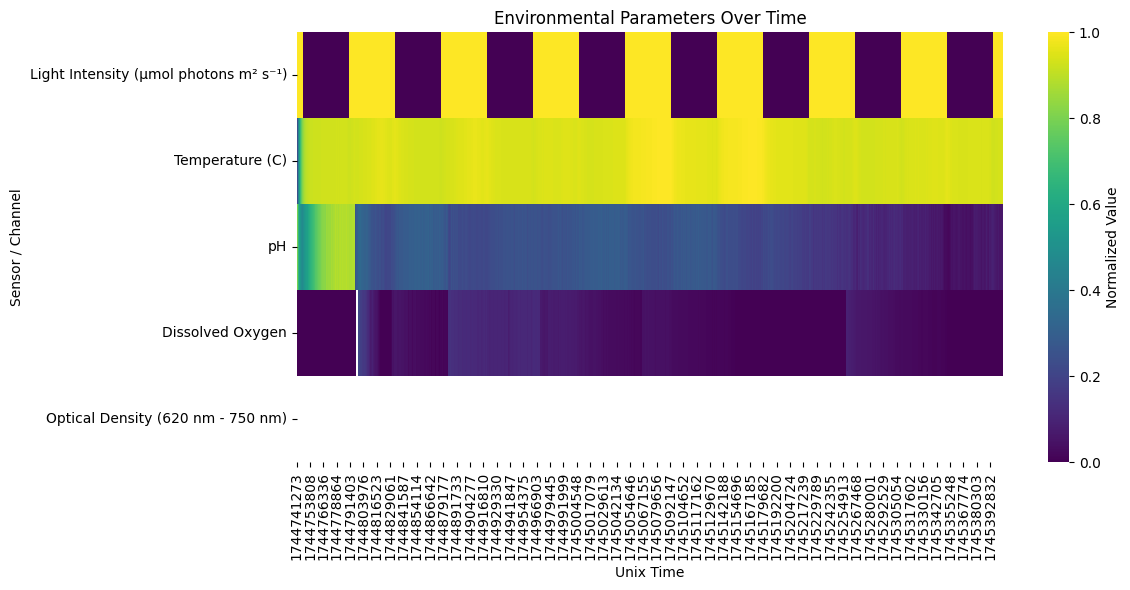

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen",
        "Optical Density (620 nm - 750 nm)",
        # "green_intensity",
        # "blue_intensity",
    ]
]
heatmap_data = heatmap_data.dropna(how="all")
heatmap_data = heatmap_data.set_index("unixtime")
normalized = (heatmap_data - heatmap_data.min()) / (
    heatmap_data.max() - heatmap_data.min()
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized.transpose(), cmap="viridis", cbar_kws={"label": "Normalized Value"}
)
plt.xlabel("Unix Time")
plt.ylabel("Sensor / Channel")
plt.title("Environmental Parameters Over Time")
plt.tight_layout()
plt.show()

/var/folders/1j/7hbmv0v92x141ltlqxmr9dzw0000gn/T/ipykernel_71849/1820459373.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=18)


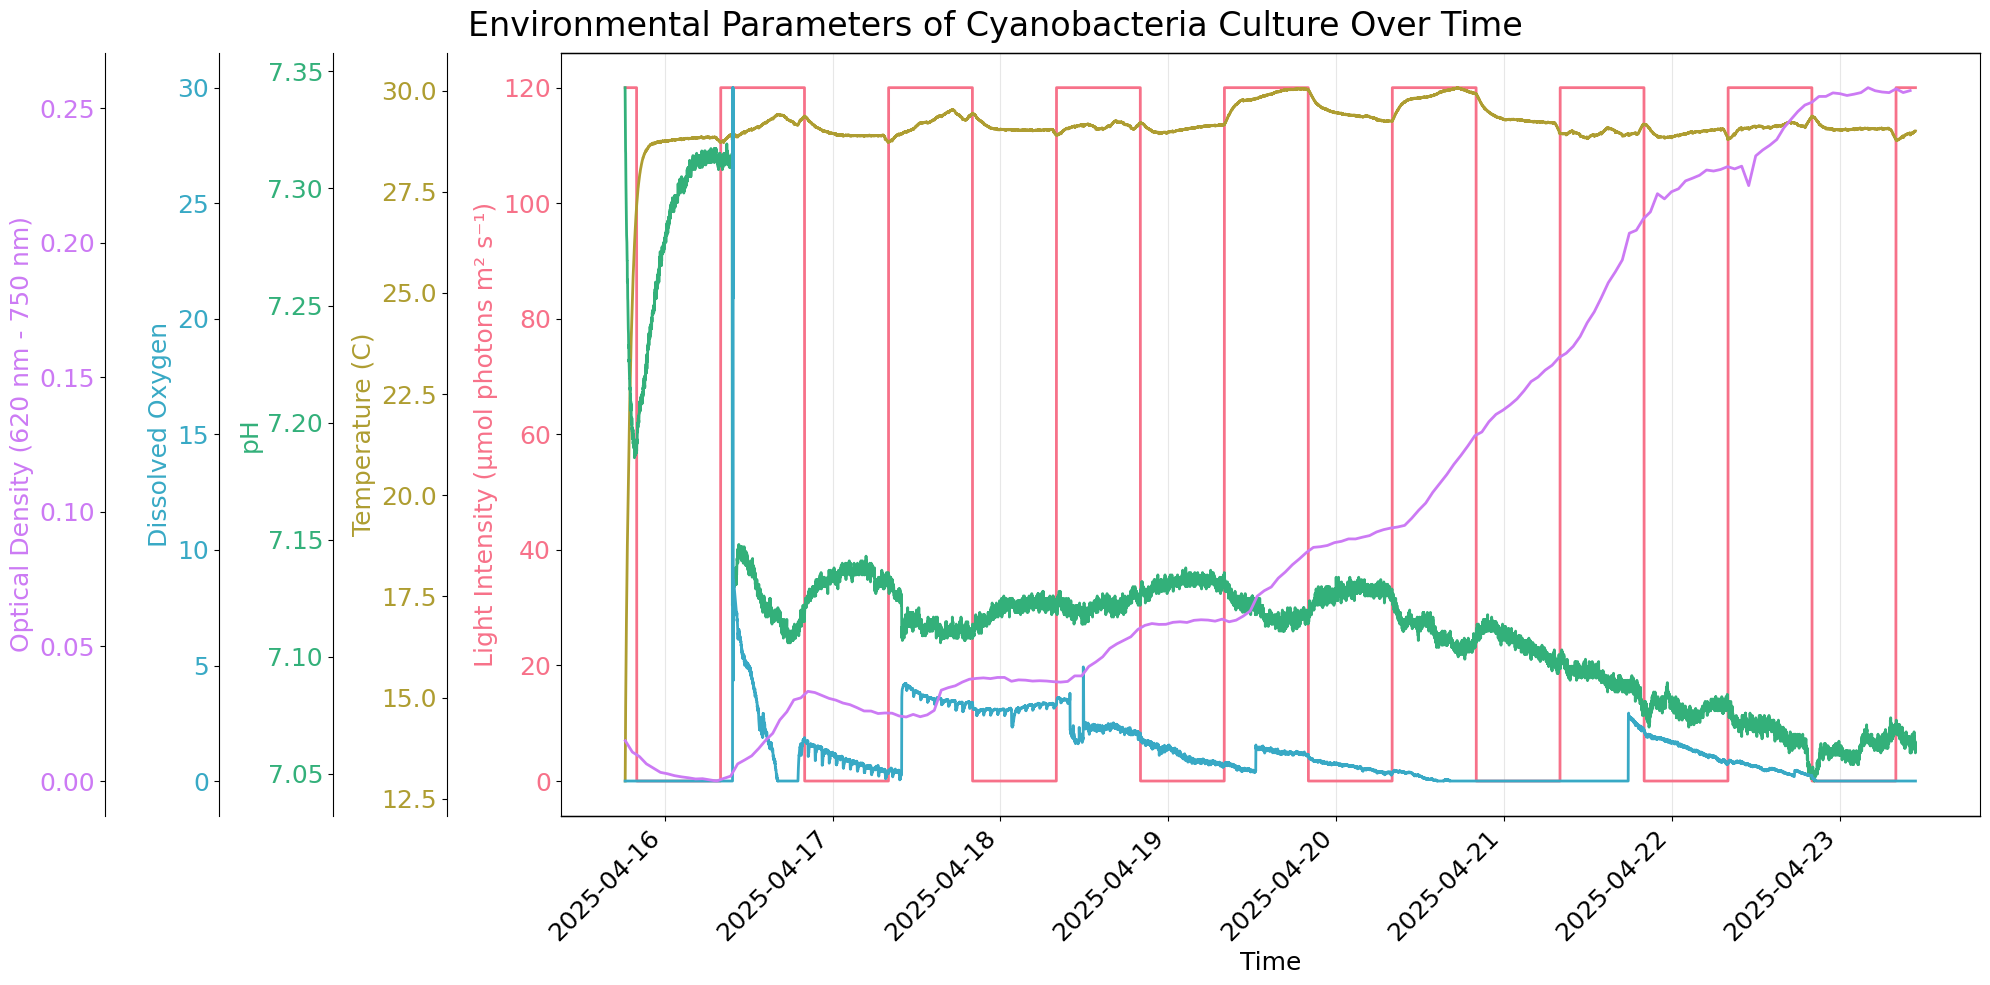

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the relevant data
lineplot_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen",
        "Optical Density (620 nm - 750 nm)",
    ]
].copy()

cols_to_downsample = [
    'Light Intensity (μmol photons m² s⁻¹)',
    "Temperature (C)",
    "pH",
    "Dissolved Oxygen",
]

for col in cols_to_downsample:
    if col in lineplot_data.columns:
        original_values = lineplot_data[col].copy()
        downsampled_series = pd.Series(np.nan, index=lineplot_data.index, dtype=original_values.dtype)
        downsampled_series.iloc[::50] = original_values.iloc[::50]
        lineplot_data[col] = downsampled_series
    else:
        print(f"Warning: Column '{col}' not found in lineplot_data for downsampling.")

lineplot_data = lineplot_data.dropna(how="all")

# Convert unixtime to datetime
lineplot_data['datetime'] = pd.to_datetime(lineplot_data['unixtime'], unit='s')
lineplot_data = lineplot_data.set_index('datetime')
lineplot_data = lineplot_data.drop(columns=['unixtime'])

# Create a color palette
columns_to_plot = lineplot_data.columns
if not columns_to_plot.empty:
    palette = sns.color_palette("husl", len(columns_to_plot))
else:
    print("Warning: No columns to plot after processing.")
    # Avoid script error if lineplot_data is empty
    columns_to_plot = pd.Index([]) 
    palette = []

fig, ax1 = plt.subplots(figsize=(20, 10))

axes = [ax1]
lines = [] # Initialize empty list for legend lines

# Plot the first variable (if any columns to plot)
if len(columns_to_plot) > 0:
    color = palette[0]
    ax1.set_xlabel('Time', fontsize=18)
    ax1.set_ylabel(columns_to_plot[0], color=color, fontsize=18)  # Increased label font size to 18
    # Plot data and get the Line2D object
    line_obj_ax1 = sns.lineplot(data=lineplot_data[columns_to_plot[0]], ax=ax1, color=color, linewidth=2, label=columns_to_plot[0], legend=False)
    # sns.lineplot returns the AxesSubplot, get the line from its .lines attribute
    if line_obj_ax1.lines:
        lines.append(line_obj_ax1.lines[0])
    
    ax1.tick_params(axis='y', labelcolor=color, labelsize=18)  # Increased tick label size to 18
    ax1.tick_params(axis='x', labelsize=18)  # Increased tick label size to 18 for x-axis
    ax1.grid(True, alpha=0.3, axis='x') # Grid only for the primary x-axis
    # ax1 is already on the left by default
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.tick_left()

# Plot subsequent variables on new y-axes, all on the left
if len(columns_to_plot) > 1:
    for i, column in enumerate(columns_to_plot[1:]): # i = 0 for 2nd var, 1 for 3rd var
        ax_new = ax1.twinx()
        axes.append(ax_new)
        color = palette[i+1]

        # --- MODIFICATIONS TO MOVE AXIS TO THE LEFT ---
        # 1. Make the default right spine invisible
        ax_new.spines["right"].set_visible(False)
        
        # 2. Make the left spine visible
        ax_new.spines["left"].set_visible(True)
        
        # 3. Position the new left y-axis spine to avoid overlap
        offset = (i + 1) * 82 
        ax_new.spines["left"].set_position(("outward", offset))
        
        # 4. Ensure ticks and label are on the left for this new axis
        ax_new.yaxis.tick_left() 
        ax_new.yaxis.set_label_position('left') # This was already in your original code for ax_new
        # --- END MODIFICATIONS ---

        # Plot the data on the new axis
        line_obj_new = sns.lineplot(data=lineplot_data[column], ax=ax_new, color=color, linewidth=2, label=column, legend=False)
        if line_obj_new.lines:
            lines.append(line_obj_new.lines[0]) # Append the Line2D object

        ax_new.set_ylabel(column, color=color, fontsize=18)  # Increased y-label font size to 18
        ax_new.tick_params(axis='y', labelcolor=color, labelsize=18) # Apply color and font size to left tick labels

        ax_new.grid(False) # Turn off grid for these additional y-axes to reduce clutter

# Rotate the x-tick labels explicitly
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right", fontsize=18)

# Add an overall title using fig.suptitle()
fig.suptitle('Environmental Parameters of Cyanobacteria Culture Over Time', fontsize=24)

# Adjust the layout to make space for all labels
plt.tight_layout()

plt.show()


# Fun little exercise to try and look thru only the columns that have complete data for correlation matrix

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the columns we're interested in
correlation_data = df_combined[
    [
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen",
        "Optical Density (620 nm - 750 nm)",
    ]
]

# Drop rows with any missing values
complete_data = correlation_data.dropna(how="any")
complete_data


,Light Intensity (μmol photons m² s⁻¹),Temperature (C),pH,Dissolved Oxygen,Optical Density (620 nm - 750 nm)
417229,120,13.57,7.334,0.0,0.014973
420984,120,24.84,7.195,0.0,0.010775
424749,0,27.86,7.205,0.0,0.009115
428512,0,28.52,7.227,0.0,0.006383
432274,0,28.68,7.250,0.0,0.004817
...,...,...,...,...,...
1090751,0,29.04,7.062,0.0,0.256091
1094514,0,29.04,7.065,0.0,0.255861
1098272,120,28.77,7.070,0.0,0.257291
1102024,120,28.85,7.066,0.0,0.255884


Original shape: (691549, 5), After dropping NAs: (192, 5)


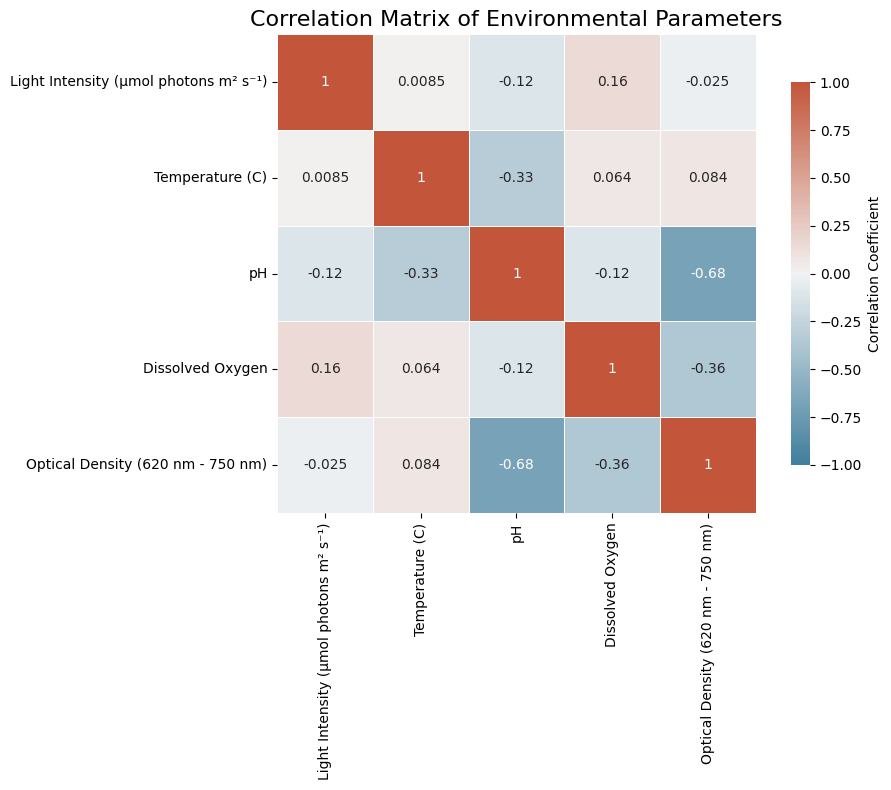


Correlation Matrix:
                                       Light Intensity (μmol photons m² s⁻¹)  \
Light Intensity (μmol photons m² s⁻¹)                                   1.00   
Temperature (C)                                                         0.01   
pH                                                                     -0.12   
Dissolved Oxygen                                                        0.16   
Optical Density (620 nm - 750 nm)                                      -0.02   

                                       Temperature (C)    pH  \
Light Intensity (μmol photons m² s⁻¹)             0.01 -0.12   
Temperature (C)                                   1.00 -0.33   
pH                                               -0.33  1.00   
Dissolved Oxygen                                  0.06 -0.12   
Optical Density (620 nm - 750 nm)                 0.08 -0.68   

                                       Dissolved Oxygen  \
Light Intensity (μmol photons m² s⁻¹)              0.1

<Figure size 1200x1000 with 0 Axes>

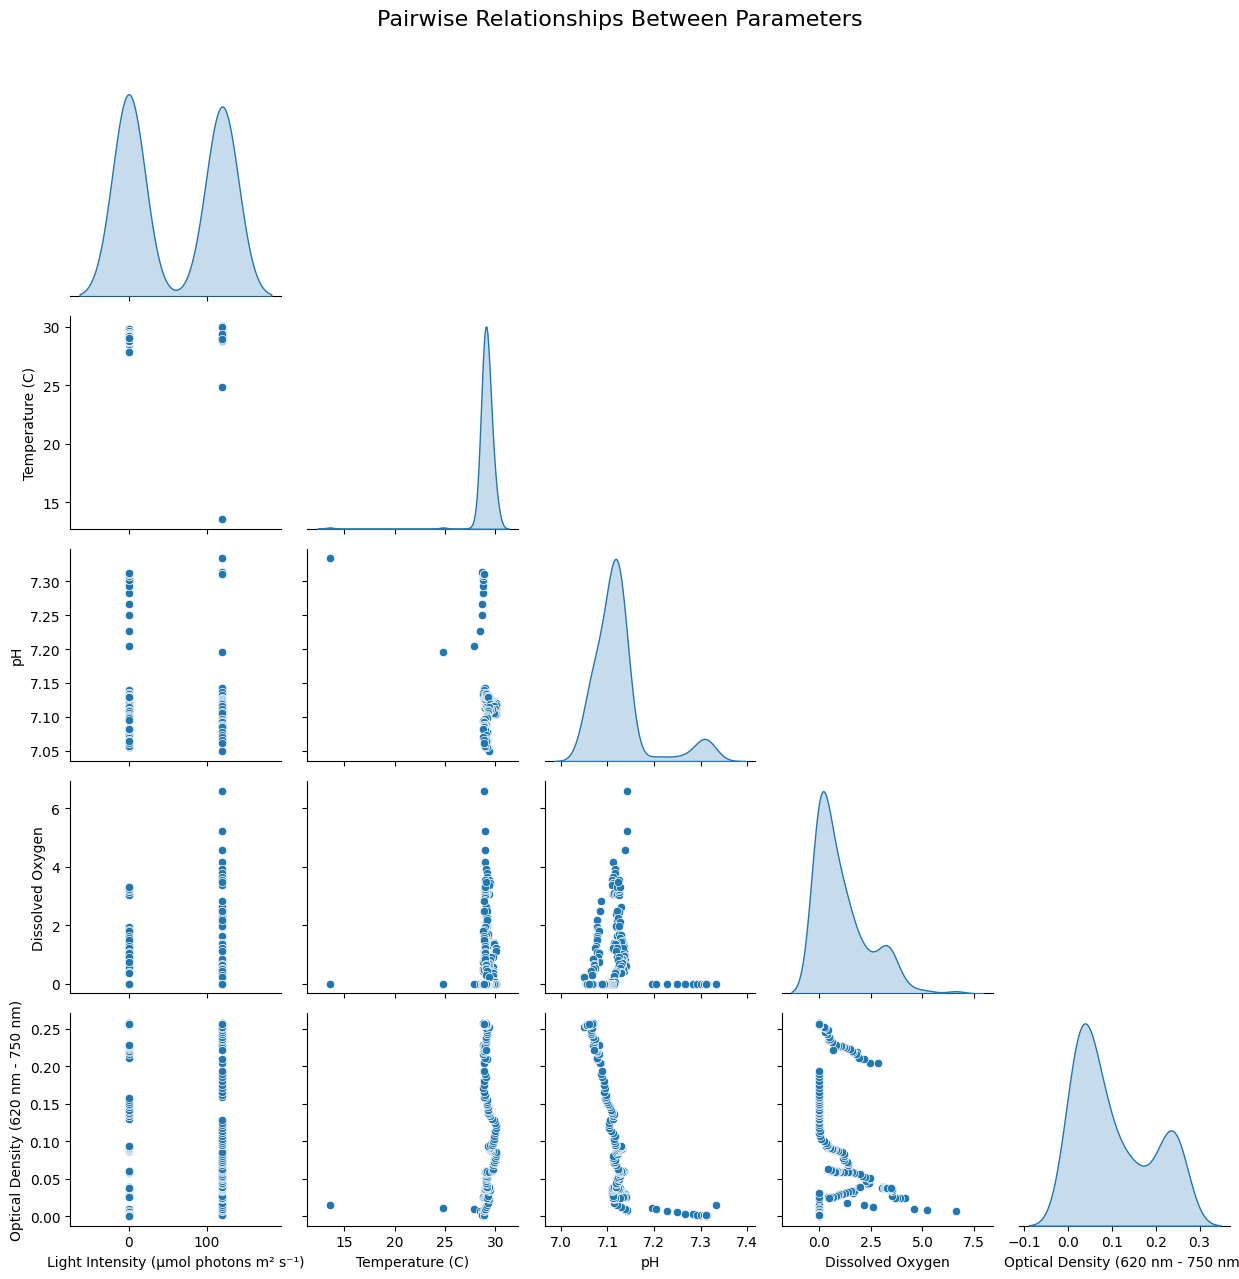

In [94]:
print(f"Original shape: {correlation_data.shape}, After dropping NAs: {complete_data.shape}")

# Calculate the correlation matrix
corr_matrix = complete_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with formatting
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Use a diverging colormap

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values
    cmap=cmap,   # Use our defined colormap
    vmax=1.0,    # Maximum correlation value
    vmin=-1.0,   # Minimum correlation value
    center=0,    # Center the colormap at zero
    square=True, # Make the cells square
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
)

plt.title('Correlation Matrix of Environmental Parameters', fontsize=16)
plt.tight_layout()
plt.show()

# Let's also look at the actual correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Additional analysis: descriptive statistics of complete data
print("\nDescriptive Statistics:")
print(complete_data.describe())

# You could also do a pairplot to see both distributions and correlations
plt.figure(figsize=(12, 10))
sns.pairplot(complete_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()